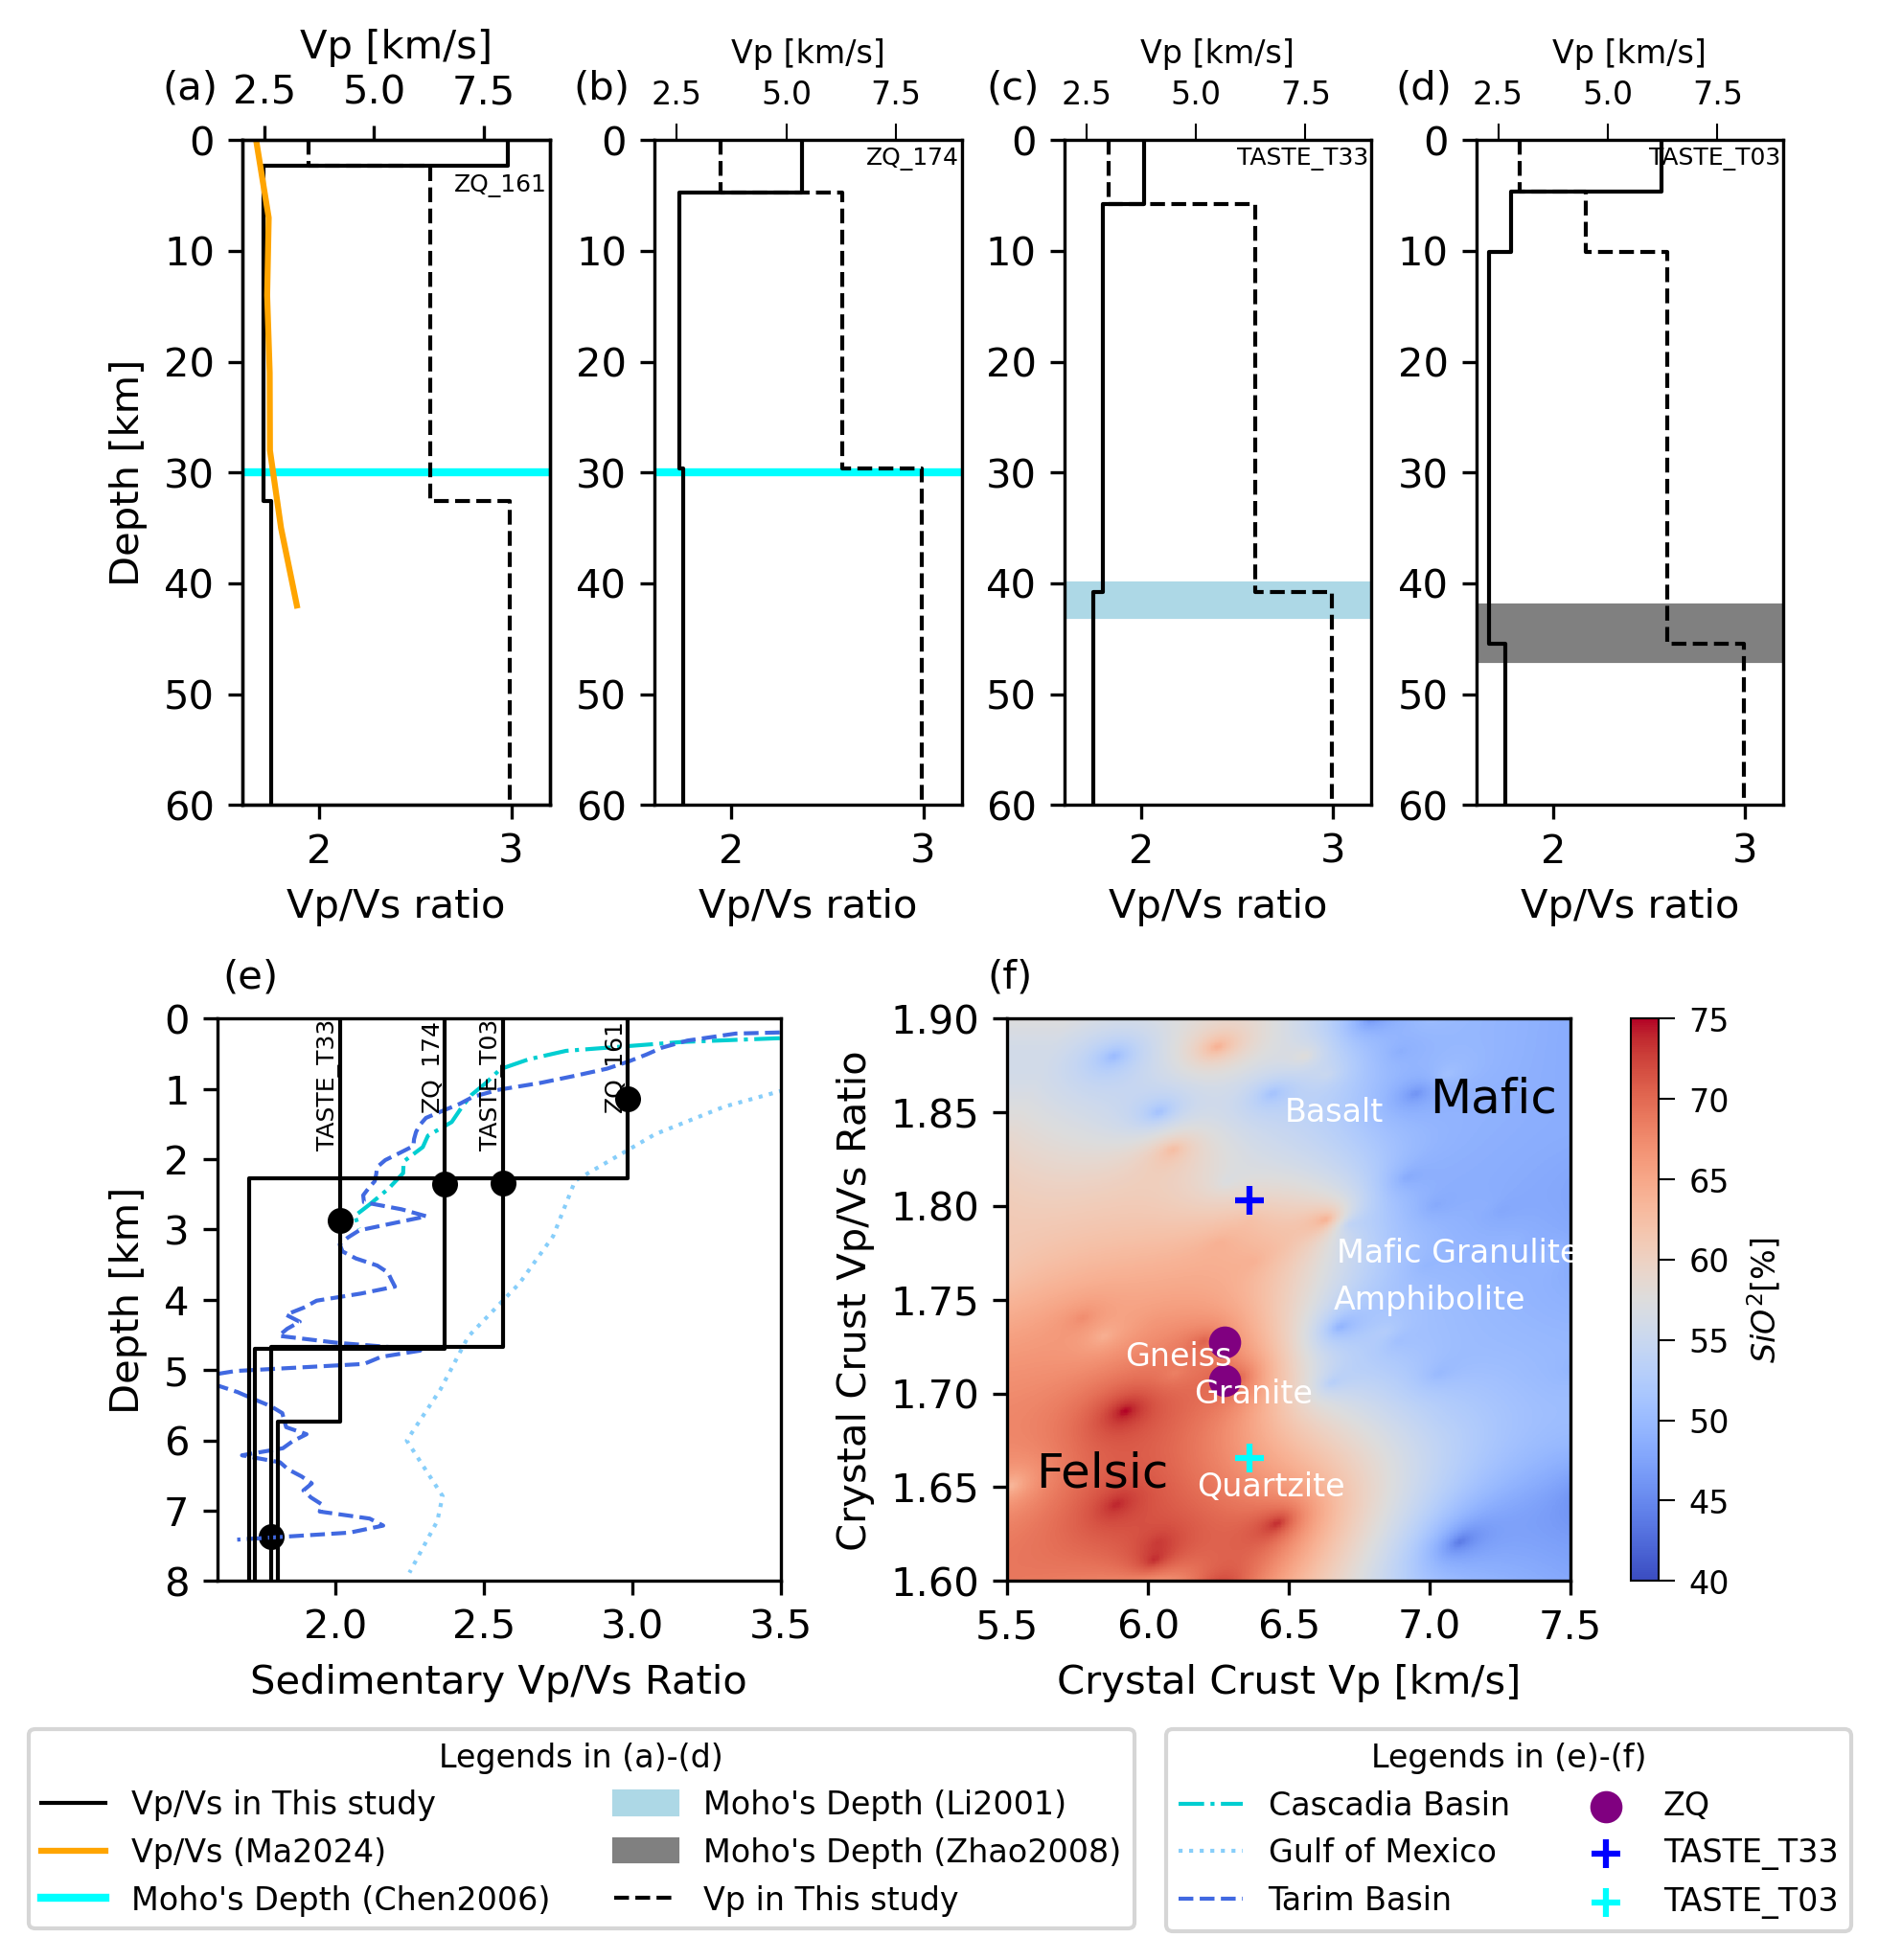

In [1]:
from HkVp_multilayer.plotting import Plot_HkVp
import matplotlib.pyplot as plt 
import numpy as np
from scipy.interpolate import RectBivariateSpline,interp1d
from scipy.interpolate import RegularGridInterpolator
plt.rcParams['figure.dpi'] = 300
depths2p = 1000*9.8*2600/1000000

labels = ["(a)","(b)","(c)","(d)","(e)","(f)"]

fig = plt.figure(layout='constrained', figsize=(15/2.54, 15/2.54))
subfigs = fig.subfigures(2,1,wspace=0.01,hspace=0.01,height_ratios=[1.2,1])
fig1 = subfigs[0]
fig2 = subfigs[1]

axs1 = fig1.subplots(1,4)
stationnames = ["ZQ_161","ZQ_174","TASTE_T33","TASTE_T03"]
markers = ["o","o","+","+"]
colors = ['purple','purple','b','cyan']
maindir = "seismic_data_RFAC"


axs2 = fig2.subplots(1,2)
ax_sedi = axs2[0]
ax_crust = axs2[1]
##plot Vp/Vs-Vp-SiO2 surface 
grid = "Supplementary_data_and_codes/Vs_VpVs_SiO2.readable.txt"

data = np.loadtxt(grid)
data = data[np.lexsort((data[:,1],data[:,0]))] # strictly ascending Vs and VpVs
vs = data[:,0]
vpvs = data[:,1]
sio2 = data[:,2]

sorted_vs = np.unique(vs)
sorted_vpvs = np.unique(vpvs)
sorted_sio2 = np.reshape(sio2,(len(sorted_vs),len(sorted_vpvs)))

interpolation2d = RectBivariateSpline(sorted_vs, sorted_vpvs, sorted_sio2)

nVp_new = 201
nK_new = 201
Vps_new = np.linspace(5.4,8.2,nVp_new)
Ks_new = np.linspace(1.6,1.9,nK_new)

sorted_sio2_new = np.zeros([nK_new,nVp_new])

for ivp in range(nVp_new):
    for ik in range(nK_new):
        sorted_sio2_new[ik,ivp] = interpolation2d(Vps_new[ivp]/Ks_new[ik],Ks_new[ik])


im = ax_crust.imshow(sorted_sio2_new,cmap='coolwarm',aspect='auto',
                extent=[Vps_new.min(),Vps_new.max(),Ks_new.min(),Ks_new.max()],
                origin='lower',vmin=40,vmax=75)
ax_crust.text(7.0,1.85,"Mafic",fontsize=12,c='k')
ax_crust.text(5.6,1.65,"Felsic",fontsize=12,c='k')
ax_crust.text(3.6*1.85,1.85,"Basalt",fontsize=8,c='w',ha='center',va='center')
ax_crust.text(3.75*1.70,1.70,"Granite",fontsize=8,c='w',ha='center',va='center')
ax_crust.text(3.55*1.72,1.72,"Gneiss",fontsize=8,c='w',ha='center',va='center')
#ax_crust.text(3.95*1.87,1.87,"Gabbro",fontsize=8,c='w',ha='center',va='center')
ax_crust.text(3.9*1.65,1.65,"Quartzite",fontsize=8,c='w',ha='center',va='center')
ax_crust.text(4.0*1.75,1.75,"Amphibolite",fontsize=8,c='w',ha='center',va='center')
ax_crust.text(4.0*1.775,1.775,"Mafic Granulite",fontsize=8,c='w',ha='center',va='center')



##logging
ks_pe1,pe1 = np.loadtxt("logging_Zhu2019_northsite.text",delimiter=',',unpack=True)
ax_sedi.plot(ks_pe1,pe1,lw=1,label="Cascadia Basin",color='darkturquoise',ls='-.')

ks_pe1,pe1 = np.loadtxt("logging_Dutta2009.text",delimiter=',',unpack=True)
ax_sedi.plot(ks_pe1,pe1,lw=1,label="Gulf of Mexico",color='lightskyblue',ls=':')

dep1,vs_log = np.loadtxt("logging_tarim_shun3_Vs.dat",delimiter=',',unpack=True)
dep2,vp_log = np.loadtxt("logging_tarim_shun3_Vp.dat",delimiter=',',unpack=True)

vs_interp = interp1d(dep1, vs_log, kind='linear', fill_value='extrapolate')
vp_interp = interp1d(dep2, vp_log, kind='linear', fill_value='extrapolate')

# 3. 确定共同的深度范围
common_dep_min = max(dep1.min(), dep2.min())
common_dep_max = min(dep1.max(), dep2.max())

# 4. 创建新的深度网格（可根据需要调整步长）
step = 0.1  # 插值步长，可根据实际情况调整
new_depth = np.arange(common_dep_min, common_dep_max + step, step)

# 5. 插值到新深度
vs_new_log = vs_interp(new_depth)
vp_new_log = vp_interp(new_depth)

# 6. 计算 vp/vs
vp_vs_ratio_log = vp_new_log / vs_new_log
ax_sedi.plot(vp_vs_ratio_log,new_depth,lw=1,label="Tarim Basin",color='royalblue',ls='--')

for m,stationname in enumerate(stationnames):
    # mi = m//2
    # mj = m%2
    # ax_k = axs[mi,mj]
    ax_k = axs1[m]
    ax_Vp = ax_k.twiny()    

    if stationname=="TASTE_T03":
        save_filename = f"Hk_result_52_pws2_3layer_Hk_result.npz"
    else:
        save_filename = f"Hk_result_52_pws2_Hk_result.npz"

    datadir = f"{maindir}/{stationname}"
    plot_instance = Plot_HkVp(savefile=f"{datadir}/{save_filename}")
    Vps,Ks,Thicks = plot_instance.get_optmodel()
    thicks_cumsum = np.cumsum(Thicks)
    Nlayer = len(Thicks)
    for ilayer in range(Nlayer-1):
        depth_now = thicks_cumsum[ilayer]-Thicks[ilayer]/2.0
        ax_sedi.scatter(Ks[ilayer],depth_now,marker='o',color='k',s=30)
    if stationname=="ZQ_161":
        ax_crust.scatter(Vps[-1],Ks[-1],marker=markers[m],color=colors[m],s=50,label='ZQ')
    elif stationname.split("_")[0]=="TASTE":
        ax_crust.scatter(Vps[-1],Ks[-1],marker=markers[m],color=colors[m],s=50,label=stationname)
    else:
        ax_crust.scatter(Vps[-1],Ks[-1],marker=markers[m],color=colors[m],s=50)

    Thicks = np.append(Thicks,0.0)
    Vps = np.append(Vps,8.1)
    Ks = np.append(Ks,1.75)
    thicks_cumsum = np.cumsum(Thicks)

    depths_plot = np.zeros([2*len(Thicks)])
    depths_plot[2::2] = thicks_cumsum[:-1]
    depths_plot[1::2] = thicks_cumsum
    depths_plot[0] = 0
    depths_plot[-1] = 60
    Vps_plot = np.zeros([2*len(Vps)])
    Vps_plot[0::2] = Vps
    Vps_plot[1::2] = Vps
    Ks_plot = np.zeros([2*len(Ks)])
    Ks_plot[0::2] = Ks
    Ks_plot[1::2] = Ks

    ax_sedi.text(Ks_plot[0], 
        depths_plot[0], 
        stationname, 
        ha='right',
        va='top',
        rotation=90,
        fontsize=6, 
        color='black', )

    ax_sedi.plot(Ks_plot,depths_plot,lw=1,color='k',ls='-')
    ax_k.plot(Ks_plot,depths_plot,lw=1,color='k',ls='-',label='Vp/Vs in This study' if stationname=="ZQ_161" else "")
    ax_Vp.plot(Vps_plot,depths_plot,lw=1,color='k',ls='--',label='Vp in This study' if stationname=="ZQ_161" else "")

    if stationname=="ZQ_161":
        filename = "BohaiBay/datasets_Ma2024/VpVs model result.txt"
        with open(filename,'r') as fd:
            lines = fd.readlines()
            line1 = lines[0].strip("\n")
            lons = line1.split()[1:]
            lons = list(map(float,lons))
            line2 = lines[1].strip("\n")
            lats = line2.split()[1:]
            lats = list(map(float,lats))
            line3 = lines[2].strip("\n")
            depths = line3.split()[1:]
            depths = list(map(float,depths))
            nlon = len(lons)
            nlat = len(lats)
            ndep = len(depths)
            Ks = np.zeros([len(lons),len(lats),len(depths)])        
            for j in range(nlat):
                for k in range(ndep):
                    line = lines[3+k*nlat+j].strip("/n")
                    data = np.array(list(map(float,line.split())))
                    Ks[:,j,k]=data
            f_k = RegularGridInterpolator((lons,lats,depths),Ks)
        filename = "BohaiBay/datasets_Ma2024/Vp model result.txt"
        with open(filename,'r') as fd:
            lines = fd.readlines()
            line1 = lines[0].strip("\n")
            lons = line1.split()[1:]
            lons = list(map(float,lons))
            line2 = lines[1].strip("\n")
            lats = line2.split()[1:]
            lats = list(map(float,lats))
            line3 = lines[2].strip("\n")
            depths = line3.split()[1:]
            depths = list(map(float,depths))
            nlon = len(lons)
            nlat = len(lats)
            ndep = len(depths)
            Ks = np.zeros([len(lons),len(lats),len(depths)])        
            for j in range(nlat):
                for k in range(ndep):
                    line = lines[3+k*nlat+j].strip("/n")
                    data = np.array(list(map(float,line.split())))
                    Ks[:,j,k]=data
            f_vp = RegularGridInterpolator((lons,lats,depths),Ks)
        #161,BL,38.016701,117.233299,
        lat = 38.016701
        lon = 117.233299
        depths = [0,7,14,21,28,35,42]
        points = []
        for depth in depths:
            points.append([lon,lat,depth])
        points = np.array(points)
        Ks_tomo = f_k(points)
        Vps_tomo = f_vp(points)
        ax_k.plot(Ks_tomo,depths,lw=1.5,c='orange',ls='-',label='Vp/Vs (Ma2024)')
        #ax_Vp.plot(Vps_tomo,depths,lw=1.5,color='orange',ls='--',label='Vp of Tomo_Ma2024')

    if stationname=="ZQ_161" or stationname=="ZQ_174":
        xmin,xmax = ax_k.get_xlim()
        ax_k.plot([1.6,3.5],[30,30],lw=2,color='cyan',alpha=1,zorder=-1,label="Moho's Depth (Chen2006)" if stationname=="ZQ_161" else "")

    if stationname=="TASTE_T33":
        xmin,xmax = ax_k.get_xlim()
        ax_k.fill_between([1.6,3.5],[40,40],[43,43],color='lightblue',zorder=-1,label="Moho's Depth (Li2001)")
    if stationname=="TASTE_T03":
        xmin,xmax = ax_k.get_xlim()
        ax_k.fill_between([1.6,3.5],[42,42],[47,47],color='gray',zorder=-1,label="Moho's Depth (Zhao2008)")

    ax_Vp.set_xlabel("Vp [km/s]")
    ax_k.set_xlabel("Vp/Vs ratio")
    if m==0:
         ax_k.set_ylabel("Depth [km]")
    ax_Vp.set_xlim(2.0,9.0)
    ax_k.set_xlim(1.6,3.2)
    ax_k.set_ylim(0,60)
    ax_Vp.invert_yaxis()
    xmin,xmax = ax_k.get_xlim()
    ymin,ymax = ax_k.get_ylim()
    if stationname=="ZQ_161":
        ax_k.text(xmin + 0.99 * (xmax - xmin), 
            ymin + 0.95 * (ymax - ymin), 
            stationname, 
            ha='right',
            va='top',
            fontsize=6, 
            color='black', )
    else:
        ax_k.text(xmin + 0.99 * (xmax - xmin), 
            ymin + 0.99 * (ymax - ymin), 
            stationname, 
            ha='right',
            va='top',
            fontsize=6, 
            color='black', )
    ax_k.text(xmin -0.08 * (xmax - xmin), 
        ymin + 1.05 * (ymax - ymin), 
        labels[m], 
        ha='right',
        va='bottom',
        fontsize=10, 
        color='black', )
    




# ax_sedi.legend(loc='lower right')
ax_sedi.set_ylabel("Depth [km]")
ax_sedi.set_xlabel("Sedimentary Vp/Vs Ratio")
ax_sedi.set_xlim(1.6,3.5)
ax_sedi.set_ylim(0,8)
ax_sedi.invert_yaxis()
xmin,xmax = ax_crust.get_xlim()
ymin,ymax = ax_crust.get_ylim()
ax_crust.text(xmin +0.01 * (xmax - xmin), 
    ymin + 1.04 * (ymax - ymin), 
    labels[5], 
    ha='left',
    va='bottom',
    fontsize=10, 
    color='black', )
fig1.colorbar(im,ax=ax_crust,label=r'$SiO^2 $'+"[%]")

ax_crust.set_xlabel("Crystal Crust Vp [km/s]")
ax_crust.set_ylabel("Crystal Crust Vp/Vs Ratio")
ax_crust.set_ylim(1.6,1.9)
ax_crust.set_xlim(5.5,7.5)

xmin,xmax = ax_sedi.get_xlim()
ymin,ymax = ax_sedi.get_ylim()
ax_sedi.text(xmin +0.01 * (xmax - xmin), 
    ymin + 1.04 * (ymax - ymin), 
    labels[4], 
    ha='left',
    va='bottom',
    fontsize=10, 
    color='black', )

# hand



fig1.legend(title="Legends in (a)-(d)",loc='upper right',	bbox_to_anchor=(0.62, -0.842),ncol=2,)
fig2.legend(title="Legends in (e)-(f)",loc='upper left',	bbox_to_anchor=(0.62, 0),ncol=2)
plt.show()


